# Linear Downscaling for Temperature (Monthly)

#### Katrina Wheelan, 4.3.20

This notebook uses various atmospheric predictors to predict maximum temperature. There is an option to add a stochastic component to the linear model.

Steps: 

- Import data
- standardize
- LASSO or manual selection linear regression using large scale predictors
- condition on month of the year
- stochastic piece --- Gaussian or Gamma distribution
- save predictions

### Importing the necessary packages

In [7]:
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
import sklearn
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression
from sklearn.model_selection import ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import os

## Input Coordinates

In [8]:
#Adjust these if needed; takes a single cell
lat = 38.125
lon = -101.875

## Prepping the Data for analysis

Run the code below or skip to the cell with the stars if you want to use pre-prepped data for (36.608, -97.488)

### Importing the predictors

In [9]:
ROOT = '/glade/p/cisl/risc/rmccrary/DOE_ESD/LargeScale_DCA/ERA-I/mpigrid/' #where the files are saved
EXT = '_19790101-20181231_dayavg_mpigrid.nc' #date range at the end of the file
SERIES = 'ERAI_NAmerica'

#The variables to use
surface_predictors = ['mslp', 'uas', 'vas'] #, 'ps']
#Each of these predictors is taken at each pressure level below
other_predictors = ['Q', 'RH', 'U', 'V', 'Z', 'Vort', 'Div']
levels = [500, 700, 850] #pressure levels

#Surface predictors
for var in surface_predictors:
    file = ROOT + var + '_' + SERIES + '_surf' + EXT
    if var == 'mslp': predictors = xr.open_dataset(file)[var]
    predictors = xr.merge([predictors, xr.open_dataset(file)[var]])

#Other predictors (at multiple pressure levels)
for var in other_predictors:
    for level in levels:
        file = ROOT + var + '_' + SERIES + '_p' + str(level) + EXT
        predictors = xr.merge([predictors, xr.open_dataset(file).rename({var: var + '_p' + str(level)})])

### Standardizing the input variables

In [10]:
#convert to pandas dataframe in order to use scikit-learn later

def standardize(variable):
    """Standardizing a variable (converting to z-scores)
    Takes as input an Xarray dataset; outputs a standardized Xarray object"""
    return (variable - np.mean(variable)) / np.std(variable)

for col in [i for i in predictors.keys()]:
    #standardize each predictor
    predictors[col] = standardize(predictors[col])

### Get observations and training data

In [11]:
#import observations
obs_file = "/glade/p/cisl/risc/narccap/obs/gridMET/common/DCA/tmax.gridMET.NAM-22i.SGP.nc"
obs = xr.open_mfdataset(obs_file).sel(time = slice('1979-01-01','2014-12-31'))

#getting training data 
#slicing input data to the date range of obs (through 2014)
X_all = predictors.sel(lat = lat, lon = lon, method = 'nearest').sel(time = slice('1980-01-01','2014-12-31'))
Y_all = obs.sel(lat = lat, lon = lon, method = 'nearest').sel(time = slice('1980-01-01','2014-12-31'))

### Conditioning by month

In [12]:
monthsAbrev = ['Jan','Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
monthsFull = ['January','February', 'March','April','May','June','July','August','September','October','November','December']

for dataset in [X_all, Y_all]:
    #adding a variable for month into the input and obs datasets
    all_preds = [key for key in dataset.keys()] #the names of the predictors
    dataset['month'] = dataset.time.dt.month
    if not 'month' in all_preds: all_preds += ['month'] #adding "month" to the list of variable names

### Add a column of ones for constants

In [13]:
#adding a column of ones for a constant (since the obs aren't normalized they aren't centered around zero)
all_preds = [key for key in X_all.keys()] #the names of the predictors
X_all['constant'] = 1 + 0*X_all[all_preds[0]] #added the last part so it's dependent on lat, lon, and time
if not 'constant' in all_preds: all_preds += ['constant'] #adding "constant" to the list of variable names

### Separate Training and Testing Data

Right now I have even years for training and odd years for testing

In [14]:
def evenOdd(ds):
    """Input: xarray dataset
        Output: even and odd year datasets as xarray objects"""
    ds['time-copy'] = ds['time']
    #classify years as even or odd
    ds['time'] =  pd.DatetimeIndex(ds.time.values).year%2 == 0
    even, odd = ds.sel(time = True), ds.sel(time = False)
    even['time'], odd['time'] = even['time-copy'],odd['time-copy']
    return even.drop('time-copy'), odd.drop('time-copy')

X_train, X_test = evenOdd(X_all)
Y_train, Y_test = evenOdd(Y_all)

In [15]:
#creating a month filter

for data in [X_train, X_test, Y_train, Y_test]:
    data['timecopy'] = data['time']
    data['time'] = data['month']

In [12]:
#saving data
for data in ['X_train', 'Y_train', 'X_test', 'Y_test']:
    eval(data).to_netcdf('/glade/work/kwheelan/linear_data/'+ data + '_temp_bymonth.nc')

## ** Or skip everything above and run this: **
(Note that this data is for lat = 38.125, lon = -101.875)

In [6]:
monthsAbrev = ['Jan','Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
monthsFull = ['January','February', 'March','April','May','June','July','August','September','October','November','December']

X_train = xr.open_dataset('/glade/work/kwheelan/linear_data/X_train_temp_bymonth.nc')
Y_train = xr.open_dataset('/glade/work/kwheelan/linear_data/Y_train_temp_bymonth.nc')
X_test = xr.open_dataset('/glade/work/kwheelan/linear_data/X_test_temp_bymonth.nc')
Y_test = xr.open_dataset('/glade/work/kwheelan/linear_data/Y_test_temp_bymonth.nc')

### Correlation matrix for all the predictors

This shows how closely related predictors are to each other.

(I can add a scatterplot matrix here if that would be useful.)

In [38]:
ds_cor_bymonth = []

for month in range(1,13):
    #subset data for each month
    X_train_month = X_train.sel(time = month)
    #get corr matix
    #you can drop any variable in the matrix by adding to the list, e.g. 'mslp', 'vas'...
    ds_cor_bymonth += [X_train_month.to_dataframe().drop(['lat','lon', 'constant', 'month'], axis=1).corr()]

#select month to see corr matrix
month = 3    #ie. month = 3 means filter for March
print("Correlation Matrix for " + str(monthsFull[month-1]))
print(ds_cor_bymonth[month-1])

Correlation Matrix for March
               mslp       uas       vas    Q_p500    Q_p700    Q_p850  \
mslp       1.000000 -0.187204 -0.275034 -0.223159 -0.251968 -0.440248   
uas       -0.187204  1.000000 -0.119431 -0.318221 -0.416421 -0.240301   
vas       -0.275034 -0.119431  1.000000  0.059687  0.131371  0.306063   
Q_p500    -0.223159 -0.318221  0.059687  1.000000  0.620364  0.389649   
Q_p700    -0.251968 -0.416421  0.131371  0.620364  1.000000  0.623826   
Q_p850    -0.440248 -0.240301  0.306063  0.389649  0.623826  1.000000   
RH_p500    0.049288 -0.226367 -0.332172  0.674426  0.332122  0.033791   
RH_p700    0.197180 -0.252308 -0.377888  0.292666  0.588935  0.119403   
RH_p850    0.261677 -0.402223 -0.300262  0.252291  0.437799  0.365875   
U_p500    -0.078279  0.129930  0.069065 -0.139015 -0.139499 -0.266404   
U_p700    -0.193892  0.377905  0.297420 -0.243624 -0.153931 -0.159796   
U_p850    -0.239172  0.934024  0.134472 -0.315720 -0.401014 -0.194030   
V_p500    -0.504942 -0

### Variance inflatation factors
These numbers show the effect that each predictor has on the coefficients of a regression equation. A high VIF suggests that the predictor is highly correlated with other predictors. Generally a VIF of more than 10 is concerning (but also all the VIFs will change if you take some variables out.)

In [41]:
vifList = []
for month in range(1,13):
    ds_cor = ds_cor_bymonth[month-1]
    vifList += [pd.DataFrame(np.linalg.inv(ds_cor.values), index = ds_cor.index, columns=ds_cor.columns)]

#printing vif values for a selected month
month = 4
vif = vifList[month-1]

print("Variance Inflation Factors for " + str(monthsFull[month-1]) + "\n")

for i in range(vif.shape[0]):
    #printing diagonal elements
    print(vif.columns[i] + ": " +str(vif.values[i,i]))

Variance Inflation Factors for April

mslp: 202.50355030642282
uas: 37.38505288010026
vas: 90.54287451316806
Q_p500: 15.555053856413203
Q_p700: 19.96423095055799
Q_p850: 14.981210081394998
RH_p500: 15.70299227473921
RH_p700: 20.947281100136138
RH_p850: 19.096435235529075
U_p500: 4.2057962720343784
U_p700: 7.018213332599612
U_p850: 43.77008167668333
V_p500: 7.81175964507932
V_p700: 18.166324848363196
V_p850: 115.30736443161166
Z_p500: 105.14744746643998
Z_p700: 324.3514851821716
Z_p850: 489.9548708528043
Vort_p500: 5.933558297438593
Vort_p700: 12.272241548215476
Vort_p850: 11.18806919969577
Div_p500: 1.2608484302089937
Div_p700: 1.6011096221637753
Div_p850: 3.564381190491413


# Linear Prediction for Max Temp

2 methods for prediction:
- Regular linear prediction with a human selection of predictors
- LASSO linear prediction

### 1. Regular linear prediction with some subset of the predictors

Comment out any predictors to omit them from the regression. This manual selection will use the same predictors for each month of the year.

In [16]:
#The predictors to include in a linear regression
#comment out any predictors to be dropped
preds_to_keep = [
 #'mslp',
 'uas',
 #'vas',
 #'ps', #doesn't exist in the input data
 'Q_p500',
 #'Q_p700',
 #'Q_p850',
 #'RH_p500',
 #'RH_p700',
 #'RH_p850',
 'U_p500',
 #'U_p700',
 #'U_p850',
 'V_p500',
 #'V_p700',
 #'V_p850',
 #'Z_p500',
 #'Z_p700',
 #'Z_p850',
 'Vort_p500',
 #'Vort_p700',
 #'Vort_p850',
 'Div_p500',
 #'Div_p700',
 #'Div_p850',
 'constant']

#Will drop any variables commented out
all_preds = [key for key in X_train.drop(['month', 'timecopy']).keys()] #the names of the predictors
preds_to_drop = [x for x in all_preds if not x in preds_to_keep]

def fit_linear_model(X, y, keys=None):
    """Use linear algebra to compute the betas for a multiple linear regression.
       Input: X (predictors) and y (obs) as xarray objects
       Output: a pandas dataframe with the betas (estimated coefficients) for each predictor"""
    if not type(X) is np.matrixlib.defmatrix.matrix:
        keys = [key for key in X.keys()]
        X = np.matrix([X[key].values for key in keys]).transpose() #X matrix; rows are days, columns are variables
    XT = X.transpose() #X transpose 
    betas = np.matmul(np.matmul(np.linalg.inv(np.matmul(XT,X)), XT), y)
    b = pd.DataFrame(index = range(1))
    for i in range(len(keys)):
        b[keys[i]] = betas[0,i] #assigning names to each coefficient
    return b

#fit a different model for each month

for month in range(1, 13):
    #get obs data
    y = Y_train.sel(time = month).tmax.values #obs values
    
    #get just subset of predictors
    x_train_subset = np.matrix([X_train.sel(time = month)[key].values for key in preds_to_keep]).transpose()
    x_test_subset = np.matrix([X_test.sel(time = month)[key].values for key in preds_to_keep]).transpose()

    #calculate coefficients for training data
    coefs = fit_linear_model(x_train_subset, y, 
                                            keys=preds_to_keep).rename(index = {0: 'coefficient'}).transpose()
    
    if month == 1: 
        coefMatrix = coefs
        
    coefMatrix[monthsFull[month-1]] = coefs.values
    
coefMatrix = coefMatrix.drop('coefficient', axis=1)
coefMatrix

,January,February,March,April,May,June,July,August,September,October,November,December
uas,6.482770,8.320903,6.144480,4.153399,4.024870,4.835501,4.826254,4.302809,4.700060,4.678999,6.070460,6.355734
Q_p500,3.631026,4.585195,0.559706,0.042522,0.662998,0.179812,-0.163913,0.095639,0.262258,0.164932,2.319197,2.570926
U_p500,-1.478692,-1.613424,-1.343560,-1.229004,-1.502897,-2.102636,-2.386801,-1.269299,-2.836960,-2.892879,0.091255,-1.477619
V_p500,0.935113,0.717658,1.378929,0.618073,0.620761,0.151030,0.762150,0.461773,0.599758,0.620019,0.693269,0.037327
Vort_p500,-1.819907,-2.254772,-3.115436,-3.060713,-3.646046,-3.130014,-2.451764,-2.442311,-2.605620,-2.381102,-3.269382,-1.912948
Div_p500,0.322947,0.246255,0.562622,0.144900,-0.000851,0.353682,-0.003483,0.055745,0.181265,0.230367,0.010835,0.271889
constant,9.391794,11.979544,16.327415,21.471595,26.323476,31.455302,33.017202,31.604475,27.838469,22.202224,12.885935,8.945395


### 2. LASSO Regression

(Using SciKit-Learn here)

We run LASSO independently on each month. So, the predictors could be different for each month.

In [17]:
#LASSO regressor that uses BIC to optimize the alpha (L1 regulator)
reg = sklearn.linear_model.LassoLarsIC(criterion = 'bic')

#getting predictor names
keys = [key for key in X_train.drop(['month', 'timecopy']).keys()]

#running LASSO for each month
for month in range(1, 13):
    
    #get obs data
    y = Y_train.sel(time = month).tmax.values #obs values

    #creating numpy matrices
    X_train_np = np.matrix([X_train.sel(time = month)[key].values for key in keys]).transpose()
    X_test_np = np.matrix([X_test.sel(time = month)[key].values for key in keys]).transpose()
    reg.fit(X_train_np, y)

    lasso_preds = [all_preds[i] for i in range(len(reg.coef_)) ] + ['LASSO constant']
    betas_LASSO = pd.DataFrame(index = lasso_preds, 
                            data = [coef for coef in reg.coef_ ] + [reg.intercept_], columns = ['January'])
    if month == 1: 
        betas_LASSO_list = betas_LASSO
        
    betas_LASSO_list[monthsFull[month-1]] = betas_LASSO.values

betas_LASSO_list = betas_LASSO_list.drop('constant', axis=0)
betas_LASSO_list

,January,February,March,April,May,June,July,August,September,October,November,December
mslp,-183.188745,-176.233236,-207.473083,-74.183611,-209.136497,-114.861638,-160.188984,-162.308555,-232.042498,-116.120208,-217.375510,-220.201113
uas,0.000000,0.755375,1.539892,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
vas,0.000000,0.000000,0.921741,1.151698,0.876311,1.138822,0.538394,0.289409,0.705598,0.563609,0.547480,0.243835
Q_p500,0.000000,0.000000,-0.125591,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Q_p700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Q_p850,2.565381,4.349202,1.681556,1.774190,1.209940,0.676300,0.000000,0.866326,0.000000,1.797296,0.839738,1.248425
RH_p500,0.000000,0.000000,0.000000,-0.583972,0.000000,0.000000,-0.446022,-0.133824,0.000000,0.000000,0.000000,0.000000
RH_p700,0.000000,0.000000,-0.427323,-0.151338,-1.148600,-0.542810,-0.236023,0.000000,-0.474965,0.000000,0.000000,0.000000
RH_p850,-1.290756,-2.238059,-0.933558,-2.092610,-1.282358,-1.957295,-1.113810,-1.946773,-0.372422,-2.368987,-1.003378,-0.721904
U_p500,-0.316142,-0.054626,-0.131456,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.728037,0.000000,-0.373856


In [19]:
#get LASSO test data
lasso_preds = lasso_preds[:-1]
x_test_lasso = [np.matrix([X_test.sel(time = month)[key].values for key in lasso_preds]).transpose() for month in range(1,13)]

#get linear hand-selected predictor test data
x_test_subset = [np.matrix([X_test.sel(time = month)[key].values for key in preds_to_keep]).transpose() for month in range(1,13)]

## Evaluating regression methods

RMSE can only decrease with fewer predictors and also that LASSO does not optimize for RMSE. So I've also included AIC as a measure of goodness-of-fit since AIC punishes models with too many predictors. 

AIC = Akaike Information Criterion = $2k - 2ln(\hat{L})$, $k$=number of predictors, $n$=number of datapoints, $\hat{L}$=solution to maximum likelihood function, here we use SSE (sum of squared error) since we assume the errors are normally distributed to get AIC = $2k + n(ln(\frac{SSE}{n}))$. A lower AIC value suggests a better fit.

In [20]:
def predict_linear(X, betas):
    """Input: X, an xarray object containing predictors (obs as rows, predictors as columnns), 
              betas, a numpy matrix of coefficients
       Output: Predictions in a numpy matrix; each row is a separate day"""
    keys = [key for key in X.keys()]
    X = np.matrix([X[key].values for key in keys]).transpose()
    return np.matmul(X, betas)

def RMSE(preds, obs):
    """Input: numpy matrix of predictions, numpy matrix of true values (for both, each row is a day)
       Output: Root mean squared error, as a float"""
    return np.sqrt(np.square(preds - obs.reshape(obs.shape[0],1)).mean())

def AIC(preds, obs, k):
    """Input: numpy matrix of predictions, 
              numpy matrix of true values (for both, each row is a day)
              k (integer), the number of predictors
       Output: Akaike's Information Criterion, as a float"""
    n = preds.shape[0] #length of time series (number of points)
    SSE = np.square(preds - obs.reshape(obs.shape[0],1)).sum() #Sum of squared errors
    return (2*k) + (n * np.log(SSE/n)) 

models = ['Handpicked Predictors', 'LASSO'] #names of each probability model
predictors = ['x_test_subset', 'x_test_lasso'] #the input data for each model
#the names of the dataframes where the coefficents are stored
betas = ['coefMatrix', 'betas_LASSO_list'] 

#creating a dataframe to save the model metrics
model_metrics = pd.DataFrame(index = models, columns = ['n_predictors','RMSE', 'AIC'])

#evaluating for each month
for month in range(1,13):
    
    print(monthsFull[month-1])
    
    #obs
    y_test_np = Y_test.sel(time=month).tmax.values #obs values for testing as numpy array

    for model,preds,betaList,i in zip(models, predictors, betas, range(len(betas))):
        #evaluating the various goodness-of-fit metrics for each model
                
        #predict values for comparison to obs 
        preds = np.matmul(eval(preds)[month-1], eval(betaList)[monthsFull[month-1]])
        #number of predictors FIX
        k = len([i for i in eval(betaList)[monthsFull[month- 1]].values if i != 0]) 
        model_metrics['n_predictors'][i] = k 
        model_metrics['RMSE'][i] = RMSE(preds, y_test_np)
        model_metrics['AIC'][i] = AIC(preds, y_test_np, k)

    #Print the table out
    print(pd.DataFrame(model_metrics))
    print("\n")

January
                      n_predictors     RMSE      AIC
Handpicked Predictors            7  7.81346  30.6461
LASSO                            9  8.58357  34.8341


February
                      n_predictors     RMSE      AIC
Handpicked Predictors            7  8.85915  30.6937
LASSO                           10  9.98886  36.9338


March
                      n_predictors     RMSE      AIC
Handpicked Predictors            7  7.80627  30.6443
LASSO                           13  9.16952  42.9662


April
                      n_predictors     RMSE      AIC
Handpicked Predictors            7  7.67709  30.5453
LASSO                           10   8.7691  36.8113


May
                      n_predictors     RMSE      AIC
Handpicked Predictors            7   6.5507  30.2935
LASSO                           12  7.39279  40.5354


June
                      n_predictors     RMSE      AIC
Handpicked Predictors            7  5.71126  29.9537
LASSO                           10  6.27295  36.141

# Getting Predictions from Chosen Regression Method

I've chosen to do LASSO regression for maximum temperature. Here I'm stitching together the different month models to get predictions for the entire testing dataset.

In [92]:
X_all_cp = X_all
X_all_cp['time'] = X_all_cp['time-copy'].dt.month
x_all_lasso = [np.matrix([X_all_cp.sel(time = month)[key].values for key in lasso_preds]).transpose() for month in range(1,13)]

for month in range(1,13):
    X_month = X_all_cp.sel(time=month)
    X_month["preds"] = X_month['time'] + X_month['lat']
    X_month["preds"]= ({'time' : 'time'}, pd.DataFrame(np.matmul(x_all_lasso[month-1], betas_LASSO_list[monthsFull[month-1]])).values[0])
    X_month['time'] = X_month['time-copy']
    if month == 1:
        X_preds = X_month
    else:
        X_preds = xr.concat([X_preds, X_month], dim = "time")
        
X_preds = X_preds.sortby('time')

# Adding a stochastic element from a distribution

(This might be similar to the 'variance factor' in the paper)

This will necessarily increase the RMSE/AIC/BIC, but it might help the distributions.

It makes less sense to add a stochastic element to temperature than to precipitation, but the model does slightly underpredict extremes.

## The raw distributions

(I could make separate distributions by month if that would be helpful)

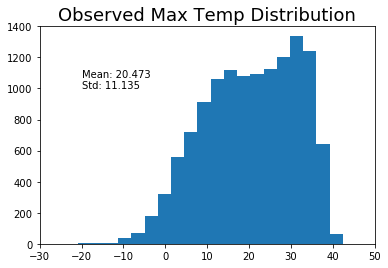

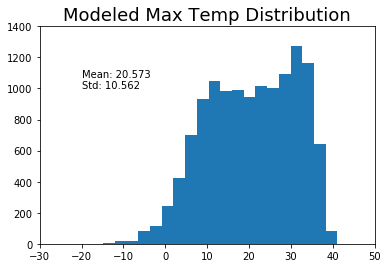

In [75]:
def plotDists(preds):
    """Plotting the true and modeled distributions on a log scale"""
    for data, title in zip([Y_all.tmax, preds], ['Observed', 'Modeled']):
        pmean = round(float(data.mean()),3) #mean
        pstd = round(float(data.std()),3) #standard deviation

        #plot details
        plt.hist(data, bins = 20)
        plt.title(title + ' Max Temp Distribution',fontsize=18) #title
        plt.xlim(xmin=-30, xmax = 50)
        plt.ylim(ymin=0, ymax = 1400)

        #show mean and std
        plt.text(-20,1000, "Mean: " + str(pmean) + "\nStd: " + str(pstd))
        plt.show()
        
plotDists(X_preds.preds)

## Adding a normal distribution element

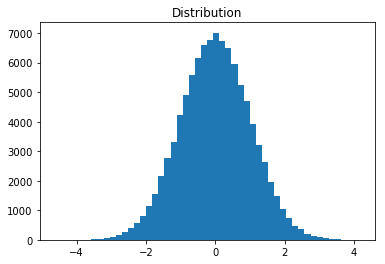

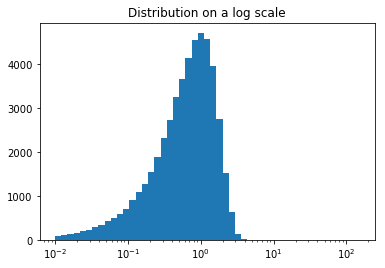

In [46]:
mu, sigma = 0, 1 #mean and standard deviation
data = np.random.normal(mu, sigma, 100000) #gettign 100,000 random points from this distribution

def makePlots(data):
    """Plotting a distibution on a normal scale and on a log scale."""
    
    #plotting a normal distribution
    plt.hist(data, bins = 50)
    plt.title('Distribution')
    plt.show()

    #plotting the same distribution on a log scale
    ax = plt.subplot()
    ax.set_xscale("log", nonposx='clip')
    logbins = np.geomspace(0.01,150, 50)
    plt.hist(data, bins=logbins)
    plt.title('Distribution on a log scale')
    plt.show()
    
makePlots(data)

## Gamma Distributions 

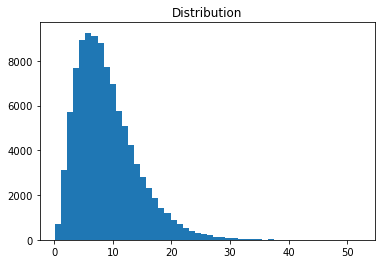

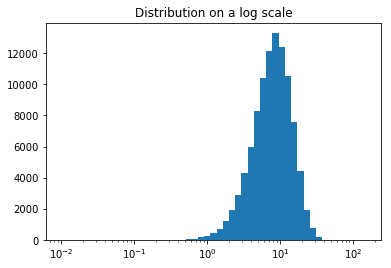

In [47]:
k = 3 #shape
theta = 3 #scale

makePlots(np.random.gamma(k,theta,100000))

## Adding a stochastic element to the predictions

You can change the distributions to see what works the best

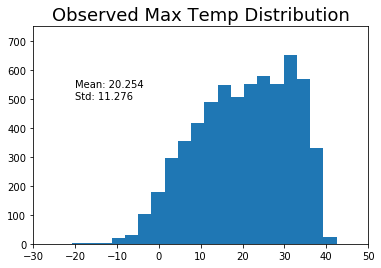

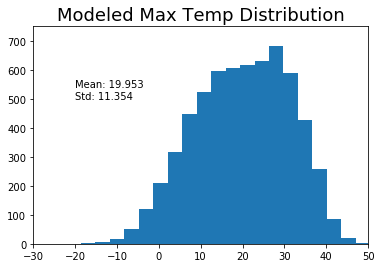

In [50]:
#Normal 
mu, sigma =-0.5, 4

#Gamma
k, theta = 2,5

np.random.seed(42)

#toggle these two lines to do a normal or gamma distribution
stochast = np.random.normal(mu, sigma, X_preds.preds.shape[0])
#stochast = np.random.gamma(k,theta,final_preds.shape[0])

corrected_preds = X_preds.preds + stochast

plotDists(corrected_preds)

### Write the final predictions to disk

In [96]:
#save location
location = '/glade/work/kwheelan/datasets'

#just saving as a txt file right now, but I could convert to xarray if needed
#saves just the predicted precip values in order of data
np.savetxt(os.path.join(location, 'oddYrPreds_TMAX' + '_'+ str(lat) + '.' + str(lon) + '.txt'), corrected_preds, delimiter = ',')

#saves the original predictions (no stochastic componenet as a netCDF)
#X_preds.to_netcdf('/glade/work/kwheelan/linear_data/finalPreds_tmax_'+ str(lat) + '_' + str(lon) + '.nc')

In [97]:
X_preds.to_netcdf('/glade/work/kwheelan/linear_data/'+ 'test' + '.nc')